## MMSD评测

In [ ]:
from PIL import Image
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
MODEL_PATH = "/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct/"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, 
                                                           attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(MODEL_PATH)




Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


In [21]:
def inference(image_path, prompt, sys_prompt="You are an expert linguist. Your task is to analyze a image-text pair and determine if it is ’sarcastic’ or ’non-sarcastic’", max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda:0')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

In [ ]:
image_path = "/data/guojian.li/Project/Video-R1/images/demo1.png"
text = "hello world, this is a test of sarcasm detection."
image = Image.open(image_path).convert("RGB")
prompt = (
    'Look at the image and read the text below. '
    'Is there any sarcasm or irony present in the combination of the image and the text? '
    '\n\n'
    f'Text: {text}'
)
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
inputs

{'input_ids': tensor([[   27,    91,  1805,    91,   397, 10380,   518,   279,  2168,   323,
          1349,   279,  1467,  3685,    13,  2160,  1052,   894, 78766, 10530,
           476, 50605,  3042,   304,   279, 10601,   315,   279,  2168,   323,
           279,  1467,    30,  4710,  1178,    25, 23811,  1879,    11,   419,
           374,   264,  1273,   315, 78766, 10530, 17984,    13]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[1.9303, 1.9157, 1.8865,  ..., 2.0890, 2.1175, 2.1175],
        [1.8865, 1.8719, 1.8427,  ..., 2.1175, 2.1032, 2.0890],
        [1.8865, 1.9011, 1.9303,  ..., 2.0890, 2.1175, 2.1032],
        ...,
        [1.8281, 1.8573, 1.8719,  ..., 2.1032, 2.0890, 2.1175],
        [1.9157, 1.8865, 1.8719,  ..., 2.1032, 2.1317, 2.1175],
        [1.8719, 1.828

In [17]:
inference(image_path, prompt)

text: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|image|>
Look at the image and read the text below. Is there any sarcasm or irony present in the combination of the image and the text? 

Text: hello world, this is a test of sarcasm detection.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



'The text provided does not contain any sarcasm or irony. It appears to be a straightforward explanation of a physics problem related to energy conservation in different types of collisions. The tone is informative and analytical, focusing on the logical reasoning behind each step of the analysis. There is no indication of humor, exaggeration, or contradiction that would suggest sarcasm or irony.'

In [17]:
def predict_sarcasm(image_path, text):
    # image = Image.open(image_path).convert("RGB")
    prompt = (
        'Please analyze the correlation between the following images and the text, and determine whether the content contains sarcasm or irony. If it is satire, please point out the satirical points (such as the contradiction between the text and the image, the contrast of the context, etc.); If not, please explain the consistency between the two.\n'
        'Requirement:\n' 
            '1. Give priority to the core semantic conflicts between the text and images\n'
            '2. Analyze in combination with social common sense and the background of online culture\n'
            '3. Output format: \n[Sarcastic Judgment] Yes/No \n[Core Analysis] Specific reasons\n\n'
        f'Text: {text}'
    )
    # inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    # outputs = model.generate(**inputs, max_new_tokens=20)
    # response = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    response = inference(image_path, prompt)

    # 简单的输出判定，可根据实际微调
    if "Yes" in response:
        return 1
    else:
        return 0

In [ ]:
import os
import json
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def inference(image_path, prompt, sys_prompt="You are a helpful assistant", max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda:2')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

# 路径配置
MODEL_PATH = "/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft-lora"
IMG_DIR = "/data/guojian.li/Dataset/MMSD/dataset_image/"
DATA_JSON = "/data/guojian.li/Dataset/MMSD/text_json_final/test.json"

# 加载模型与处理器
device = "cuda:2" if torch.cuda.is_available() else "cpu"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, 
                                                           attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

def predict_sarcasm(image_path, text):
    # image = Image.open(image_path).convert("RGB")
    prompt = (
        # 'Look at the image and read the text below. '
        # 'Is there any sarcasm or irony present in the combination of the image and the text? '
        # 'Answer only with "Yes" or "No".\n\n'
        # f'Text: {text}'
        'I will now provide you with an image and a text. Your task is to analyze the image-text pair and determine if it is sarcastic or non-sarcastic. '
        'Answer only with "Yes" or "No".\n\n'
        f'The provided text is as follows:{text}'
    )
    # inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    # outputs = model.generate(**inputs, max_new_tokens=20)
    # response = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    response = inference(image_path, prompt)

    # 简单的输出判定，可根据实际微调
    if "Yes" in response:
        return 1
    else:
        return 0

def main():
    with open(DATA_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)

    y_true, y_pred = [], []
    for item in tqdm(data):
        image_id = item["image_id"]
        text = item["text"]
        label = item["label"]
        image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            print(f"图片不存在: {image_path}")
            continue
        pred_label = predict_sarcasm(image_path, text)
        y_true.append(label)
        y_pred.append(pred_label)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"准确率: {acc:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")

if __name__ == "__main__":
    main()


/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-04 10:16:42,529] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Loading checkpoint shards: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
 22%|██▏       | 527/2409 [11:03<56:12,  1.79s/it]  

Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
100%|██████████| 2409/2409 [11:03<00:00,  3.63it/s]
准确率: 0.6766
精确率: 0.7549
召回率: 0.3684
F1分数: 0.4951

100%|██████████| 2409/2409 [11:03<00:00,  3.63it/s]
准确率: 0.6758
精确率: 0.7550
召回率: 0.3655
F1分数: 0.4925

cot
0.7057
0.7071
0.5400
0.6124

微调后
100%|██████████| 2409/2409 [11:31<00:00,  3.48it/s]
准确率: 0.7746
精确率: 0.6706
召回率: 0.9364
F1分数: 0.7815

和微调prompt一样
100%|██████████| 2409/2409 [11:10<00:00,  3.59it/s]
准确率: 0.7883
精确率: 0.6857
召回率: 0.9383
F1分数: 0.7923

'Given a tweet that consists of a text and an image. '
        'Is there any sarcasm or irony present in the combination of the image and the text? '
        'Answer only with "Yes" or "No".\n\n'
        f'Text: {text}'

100%|██████████| 2409/2409 [11:22<00:00,  3.53it/s]
准确率: 0.6505
精确率: 0.7628
召回率: 0.2729
F1分数: 0.4020

MMSD clean
100%|██████████| 2373/2373 [33:33<00:00,  1.18it/s] 
准确率: 0.6915
精确率: 0.6867
召回率: 0.3838
F1分数: 0.4924

In [2]:
import os
import json
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
MODEL_PATH = "/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct"
IMG_DIR = "/data/guojian.li/Dataset/MMSD/dataset_image/"
DATA_JSON = "/data/guojian.li/Dataset/MMSD/text_json_final/test.json"

# 加载模型与处理器
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, 
                                                           attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

Loading checkpoint shards: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
def inference(image_path, prompt, sys_prompt="""
    You are a multimodal satire analysis assistant.\n
    Please output strictly in accordance with the following structure:\n
    <think> Natural Language Interpretation </think><bbox_2d> coordinates or none</bbox_2d><answer> sarcasm/non-sarcasm </answer>\n\n
    Explanation:\n
    1. In <think> Explain "Why judge (not) sarcasm".\n
    2. <bbox> section:\n
        If answer= sarcasm, give the coordinates '[x1,y1,x2,y2],[x1,y1,x2,y2]'. The target of satire may be more than one.\n
        If answer= non-sarcasm, write single token 'none'.
    3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.
""", max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda:0')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

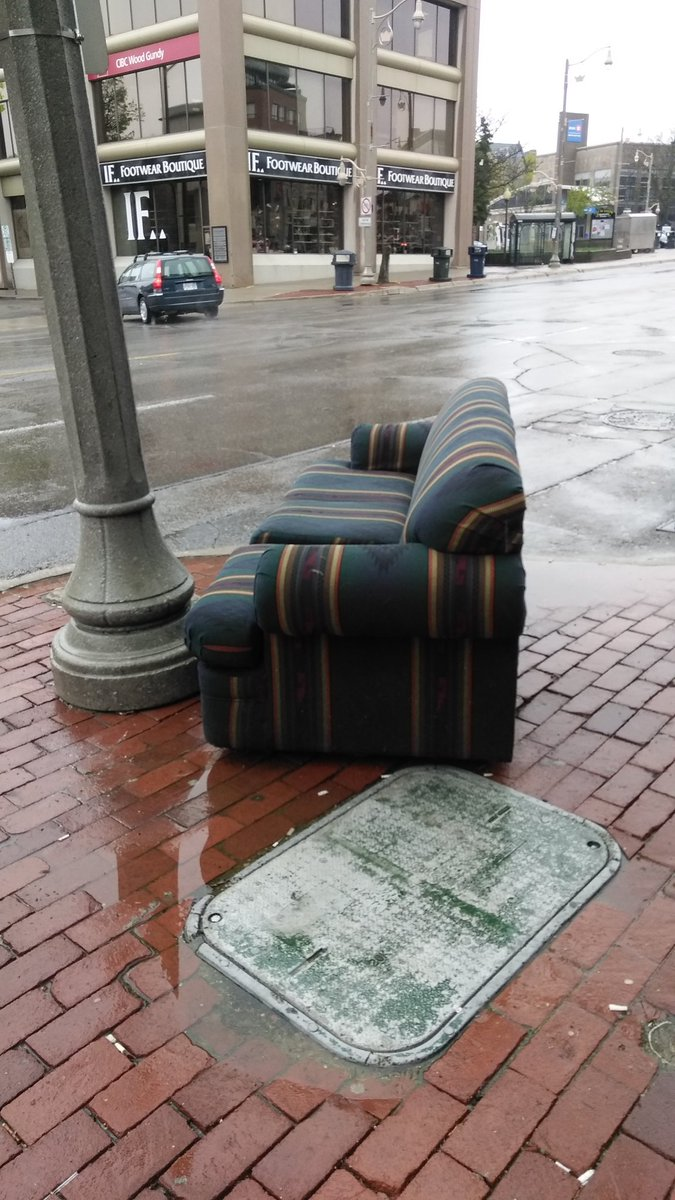

In [4]:
image1 = Image.open("/data/guojian.li/Dataset/MMSD/dataset_image/859056671179636737.jpg")
image1

In [5]:
text1 = "dump your furniture on the sidewalk & leave . the city of guelph will clean it up . of"
prompt1 = (
         f"""
            <text>{text1}</text>\n
            Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
            Just output it in the prescribed format. No extra text is needed.
        """
)
image1_path = "/data/guojian.li/Dataset/MMSD/dataset_image/859056671179636737.jpg"
response1 = inference(image1_path,prompt1)
response1

"<think> The statement suggests that the city of Guelph will clean up discarded furniture left on the sidewalk, which is an unusual and humorous claim given the typical lack of such services. This implies a sarcastic tone towards the city's efficiency or the absurdity of the situation.</think><bbox_2d>[0,0,672,1204]</bbox_2d><answer>sarcasm</answer>"

In [3]:
text1 = "dump your furniture on the sidewalk & leave . the city of guelph will clean it up . of"
prompt1 = (
        'I will now provide you with an image and a text. Your task is to analyze the image-text pair and determine if it is sarcastic or non-sarcastic. '
        'You need think step-by-step and analyze the relationship between the text and image carefully from two perspectives.'
        'If what it is expressing is satire, a reason needs to be given. If what it is expressing is not satire, a reason also needs to be given.'
        'Finally, based on thinking from two perspectives, infer the true answer.'
        'Explain your two analyses from different perspectives in <think1></think1> and <think2></think2> and output the final result in <answer></answer>.If there is a sarcastic answer, The content within <answer></answer> is "Yes".'
        ' Your final answer should be a JSON object in the following format:\n'
            '<think1> your first reasoning content </think1> <think2> your second reasoning content </think2> <answer>Yes or No</answer> \n\n'
        f'The provided text is as follows:{text1}'
    )
image1_path = "/data/guojian.li/Dataset/MMSD/dataset_image/859056671179636737.jpg"
response1 = inference(image1_path,prompt1)
response1

'<think1> The text is sarcastic because it is expressing that the city of guelph is so efficient at cleaning up furniture left on the sidewalk that people can just leave their furniture on the sidewalk and the city will clean it up for them. This is clearly not the case and is meant to be humorous.</think1> <think2> The text is sarcastic because it is expressing that the city of guelph is so efficient at cleaning up furniture left on the sidewalk that people can just leave their furniture on the sidewalk and the city will clean it up for them. This is clearly not the case and is meant to be humorous.</think2> <answer>Yes</answer>'

In [1]:
import os,re
import json
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def inference(image_path, prompt, sys_prompt=(
    "You are a multimodal satire analysis assistant.\n"
    "Please output strictly in accordance with the following structure:\n"
    "'<think> Natural Language Interpretation </think><bbox_2d> coordinates or none</bbox_2d><answer> sarcasm/non-sarcasm </answer>'\n\n"
    
    "Explanation:\n"
    "1. In <think> Explain 'Why judge (not) sarcasm'.\n"
    "2. <bbox_2d> section:\n"
        "If answer= sarcasm, give the coordinates of satirical target '[x1,y1,x2,y2] ,[x1,y1,x2,y2]'. "
        "The target of satire may be more than one, or there may be none. If not, write single token 'none'.\n"
        "If answer= non-sarcasm, write single token 'none'."
    "3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.\n\n"
    
    "The following are some relevant examples:\n"
    "1.An example of satire:\n"
        "<think> The description of the environment in the text does not match the promotion, and irony is used to express satire. </think>"
        "<bbox_2d>[23,45,44,78],[10,20,32,40]</bbox_2d><answer> sarcasm </answer>\n"
    "2.An example of non-sarcasm:\n"
        "<think> The text normally describes the feelings brought by fine weather, without any sarcasm. </think>"
        "<bbox_2d>none</bbox_2d><answer> non-sarcasm </answer>"
), 
max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda:0')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

# 路径配置
MODEL_PATH = "/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct/"
IMG_DIR = "/data/guojian.li/Dataset/MMSD/dataset_image/"
DATA_JSON = "/data/guojian.li/Dataset/MMSD/text_json_final/test.json"

# 加载模型与处理器
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, 
                                                           attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

def predict_sarcasm(image_path, text):
    # image = Image.open(image_path).convert("RGB")
    prompt = (
        f"""
            Text:{text}\n
            Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
            There are only two categories: sarcasm and non-sarcasm. Just output it in the prescribed format. No extra text is needed.
        """
    )
    # inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    # outputs = model.generate(**inputs, max_new_tokens=20)
    # response = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    response = inference(image_path, prompt)

    with open("./data/output.txt", "a", encoding="utf-8") as file:
        file.write("\n" + response)  # 追加一行


    match = re.search(r'<answer>(.*?)</answer>', string=response)

    if match:
        answer = match.group(1)
        # 简单的输出判定，可根据实际微调
        if "sarcasm" == answer:
            return 1
        else:
            return 0
    else:
        print(f"未能正确解析响应: {response}")
        return 1

def main():
    with open(DATA_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)

    y_true, y_pred = [], []
    for item in tqdm(data):
        image_id = item["image_id"]
        text = item["text"]
        label = item["label"]
        image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            print(f"图片不存在: {image_path}")
            continue
        pred_label = predict_sarcasm(image_path, text)
        y_true.append(label)
        y_pred.append(pred_label)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"准确率: {acc:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")

if __name__ == "__main__":
    main()


/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-01 15:09:56,031] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
  9%|▉         | 216/2409 [14:00<26:22:38, 43.30s/it]

未能正确解析响应: <think> The text expresses a sarcastic tone towards the idea of having laws against using a handwashing sink for other purposes, implying that such laws are unnecessary and potentially absurd. The statement "we need bigger gov't" further emphasizes the sarcasm by suggesting that the government should be expanded to enforce such trivial laws.</think><bbox_2d>[260,479,468,519] [291,518,438,546] [263,555,476,595] [263,595,449,619] [263,619,424,635] [263,635,475,651] [263,651,424,667] [263,667,475,683] [263,683,424,699] [263,699,475,715] [263,715,424,731] [263,731,475,747] [263,747,424,763] [263,763,475,779] [263,779,424,795] [263,795,475,811] [263,811,424,827] [263,827,475,843] [263,843,424,859] [263,859,475,875] [263,875,424,891] [263,891,475,907] [263,907,424,923] [263,923,475,939] [263,939,424,955] [263,955,475,971] [263,971,424,987] [263,987,475,1003] [263,1003,424,1019] [263,1019,475,1035] [263,1035,424,1051] [263,1051,475,1067] [263,1067,424,1083] [263,1083,475,1099] [263,

 19%|█▉        | 460/2409 [29:34<23:47:29, 43.95s/it]

未能正确解析响应: <think> The phrase "job creator" is often used to describe someone who creates jobs, but in the context of the comic, it seems to be used sarcastically as the character is shown to be dismissive of coal miners, who are struggling financially. This suggests that the phrase is being used ironically to highlight the character's lack of empathy towards those who need jobs.</think><bbox_2d>[69,1004,292,1160],[252,967,404,1060],[10,940,395,1060],[498,967,620,1050],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1027],[650,938,813,1

 21%|██        | 504/2409 [34:10<23:09:26, 43.76s/it]

未能正确解析响应: <think> The statement "let's end violence against women, except for women in the womb" is presented as if it were a serious proposal, which is inherently ironic and satirical. It suggests that violence against women is acceptable when they are pregnant, which is a highly controversial and unethical stance.</think><bbox_2d>[36,139,615,220],[36,210,541,252],[36,266,541,300],[36,314,620,352],[36,396,518,434],[36,449,576,487],[36,502,481,536],[36,540,481,564],[36,675,617,709],[36,725,630,761],[36,782,579,814],[36,834,624,866],[36,887,603,920],[36,941,607,973],[36,994,607,1026],[36,1047,565,1079],[36,1099,565,1131],[36,1153,565,1185],[36,1206,565,1238],[36,1260,565,1292],[36,1314,565,1346],[36,1368,565,1400],[36,1422,565,1454],[36,1476,565,1508],[36,1530,565,1562],[36,1584,565,1616],[36,1638,565,1670],[36,1692,565,1724],[36,1746,565,1778],[36,1800,565,1832],[36,1854,565,1886],[36,1908,565,1940],[36,1962,565,1994],[36,2016,565,2048],[36,2070,565,2102],[36,2124,565,2156],[36,2178,56

 22%|██▏       | 541/2409 [38:26<22:47:19, 43.92s/it]

未能正确解析响应: <think> The statement "and this is why donald trump is the hero america deserves" is a sarcastic comment, implying that Donald Trump is not a hero but rather someone who represents the worst aspects of American society. This is a form of satire targeting Trump's perceived qualities and his impact on America.</think><bbox_2d>[169,155,221,177] [226,155,278,177] [283,155,335,177] [340,155,392,177] [398,155,449,177] [455,155,507,177] [513,155,565,177] [571,155,623,177] [629,155,681,177] [687,155,739,177] [745,155,797,177] [803,155,840,177] [846,155,890,177] [896,155,940,177] [946,155,990,177] [996,155,1040,177] [1046,155,1090,177] [1106,155,1158,177] [1164,155,1216,177] [1222,155,1274,177] [1280,155,1332,177] [1338,155,1390,177] [1406,155,1458,177] [1474,155,1526,177] [1542,155,1594,177] [1610,155,1662,177] [1678,155,1730,177] [1746,155,1798,177] [1814,155,1866,177] [1882,155,1934,177] [1950,155,2002,177] [2018,155,2070,177] [2086,155,2138,177] [2154,155,2206,177] [2222,155,2274,

 38%|███▊      | 921/2409 [1:01:17<18:19:04, 44.32s/it]

未能正确解析响应: <think> The text uses the term "snowflake" in a way that is typically derogatory towards those who are perceived as overly sensitive or politically correct. This is a common form of political satire directed at supporters of Donald Trump, who often use such terms to dismiss their opponents. The image of snow-covered cars adds to the satirical effect by visually representing the idea of being "snowed under" or overwhelmed by political correctness.</think><bbox_2d>[196,277,275,332] [232,189,283,256] [218,159,275,210] [242,126,279,159] [214,120,244,146] [209,105,237,127] [189,152,224,181] [163,189,199,234] [189,132,218,155]  [288,133,310,152] [290,110,310,128] [290,98,310,114] [288,85,310,102] [288,72,310,88] [288,59,310,75] [288,46,310,62] [288,34,310,50] [288,22,310,38] [288,9,310,25] [288,1,310,17] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] [288,0,310,16] 

 62%|██████▏   | 1483/2409 [1:32:11<11:13:25, 43.63s/it]

未能正确解析响应: <think> The text uses irony to convey that promoting the show is not the intention, which is a form of satire. The phrase "it's not to promote the show!" is a clear indication of sarcasm.</think><bbox_2d>[16,99,30,122] [16,122,30,145] [16,145,30,168] [16,168,30,191] [16,191,30,214] [16,214,30,237] [16,237,30,260] [16,260,30,283] [16,283,30,306] [16,306,30,329] [16,329,30,352] [16,352,30,375] [16,375,30,398] [16,398,30,421] [16,421,30,444] [16,444,30,467] [16,467,30,490] [16,490,30,513] [16,513,30,536] [16,536,30,559] [16,559,30,582] [16,582,30,605] [16,605,30,628] [16,628,30,651] [16,651,30,674] [16,674,30,697] [16,697,30,720] [16,720,30,743] [16,743,30,766] [16,766,30,789] [16,789,30,812] [16,812,30,835] [16,835,30,858] [16,858,30,881] [16,881,30,904] [16,904,30,927] [16,927,30,950] [16,950,30,973] [16,973,30,996] [16,996,30,1019] [16,1019,30,1042] [16,1042,30,1065] [16,1065,30,1088] [16,1088,30,1111] [16,1111,30,1134] [16,1134,30,1157] [16,1157,30,1180] [16,1180,30,1203] [1

 81%|████████  | 1940/2409 [1:57:37<5:45:24, 44.19s/it] 

未能正确解析响应: <think> The phrase "read goodness" combined with the context of a panel discussion suggests a sarcastic tone, implying that the event might not be as good as it sounds.</think><bbox_2d>[169,702,299,727] [226,725,375,752] [446,725,646,752] [636,742,783,765] [856,742,1092,778] [818,758,987,795] [987,795,1203,824] [987,852,1203,896] [1184,797,1203,824] [1158,824,1203,852] [1158,852,1203,880] [1158,880,1203,900] [1158,900,1203,924] [1158,924,1203,944] [1158,944,1203,968] [1158,968,1203,992] [1158,992,1203,1008] [1158,1008,1203,1036] [1158,1036,1203,1064] [1158,1064,1203,1092] [1158,1092,1203,1116] [1158,1116,1203,1140] [1158,1140,1203,1164] [1158,1164,1203,1188] [1158,1188,1203,1212] [1158,1212,1203,1236] [1158,1236,1203,1260] [1158,1260,1203,1284] [1158,1284,1203,1308] [1158,1308,1203,1332] [1158,1332,1203,1356] [1158,1356,1203,1380] [1158,1380,1203,1404] [1158,1404,1203,1428] [1158,1428,1203,1452] [1158,1452,1203,1476] [1158,1476,1203,1500] [1158,1500,1203,1524] [1158,1524,1203

 84%|████████▍ | 2029/2409 [2:04:20<4:35:37, 43.52s/it]

未能正确解析响应: <think> The text "WE ALL DESERVE MORNING SEX AND PANCAKES" is presented in a way that is likely intended to be humorous or ironic, as it contrasts the idea of morning sex with pancakes, which are typically associated with breakfast. This juxtaposition could be seen as sarcastic, implying that the statement is not meant to be taken literally but rather as a humorous exaggeration.</think><bbox_2d>[23,269,1179,474],[126,480,775,682],[406,688,1143,890],[816,480,1085,682],[100,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,887],[126,688,358,8

100%|██████████| 2409/2409 [2:23:36<00:00,  3.58s/it]  

准确率: 0.6193
精确率: 0.5380
召回率: 0.8197
F1分数: 0.6496


In [3]:
print(
    "You are a multimodal satire analysis assistant.\n"
    "Please output strictly in accordance with the following structure:\n"
    "'<think> Natural Language Interpretation </think><bbox_2d> coordinates or none</bbox_2d><answer> sarcasm/non-sarcasm </answer>'\n\n"
    
    "Explanation:\n"
    "1. In <think> Explain 'Why judge (not) sarcasm'.\n"
    "2. <bbox_2d> section:\n"
        "If answer= sarcasm, give the coordinates of satirical target '[x1,y1,x2,y2],[x1,y1,x2,y2]', separated by ','. "
        "The target of satire may be more than one, or there may be none. If not, write single token 'none'.\n"
        "If answer= non-sarcasm, write single token 'none'."
    "3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.\n\n"
    
    "The following are some relevant examples:\n"
    "1.An example of satire:\n"
        "<think> The description of the environment in the text does not match the promotion, and irony is used to express satire </think>"
        "<bbox_2d>[23,45,44,78],[10,20,32,40]</bbox_2d><answer> sarcasm </answer>\n"
    " 2.An example of non-sarcasm:\n"
        "<think> The text normally describes the feelings brought by fine weather, without any sarcasm. </think>"
        "<bbox_2d>none</bbox_2d><answer> non-sarcasm </answer>"
)

You are a multimodal satire analysis assistant.
Please output strictly in accordance with the following structure:
'<think> Natural Language Interpretation </think><bbox_2d> coordinates or none</bbox_2d><answer> sarcasm/non-sarcasm </answer>'

Explanation:
1. In <think> Explain 'Why judge (not) sarcasm'.
2. <bbox_2d> section:
If answer= sarcasm, give the coordinates of satirical target '[x1,y1,x2,y2],[x1,y1,x2,y2]', separated by ','. The target of satire may be more than one, or there may be none. If not, write single token 'none'.
If answer= non-sarcasm, write single token 'none'.3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.

The following are some relevant examples:
1.An example of satire:
<think> The description of the environment in the text does not match the promotion, and irony is used to express satire </think><bbox_2d>[23,45,44,78],[10,20,32,40]</bbox_2d><answer> sarcasm </answer>
 2.An